### Welcome to my E-Commerce Analysis! 

#### Throughout this notebook, I will explore patterns and draw conclusions for an online retailer based in the UK. This data can be found online at kaggle.com.

#### I do not have a specfic question for this dataset to drive this analysis - rather, I will crack open the dataset and let the data drive this exploration. The ultimate goal is to understand trends and patterns enough to help this company make informed decisions regarding their operations, marketing, and manufacturing strategies. 

#### The majority of this project is quieried in SparkSQL within a PySpark session. 

#### Let's begin!

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('deep')

In [2]:
spark = SparkSession.builder \
        .appName('Online-Retail-Visualization') \
        .getOrCreate()

In [3]:
df = spark.read.csv(r'c://users/casti/OneDrive/Documents/Coding Projects/SQL Projects/On_Re.csv', header=True, inferSchema=True)

In [4]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [5]:
df.show(10)

+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|_c0|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|  0|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|  1|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|  2|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|  3|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|  4|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|  5|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United K

### There are a few different approaches I can take to questions with this dataset. Let's start off easy: we want to make money, and the best predictors of the future are the things that have already taken place. So, we should keep an eye on the most sold items to know how we may direct our resources most efficiently. 

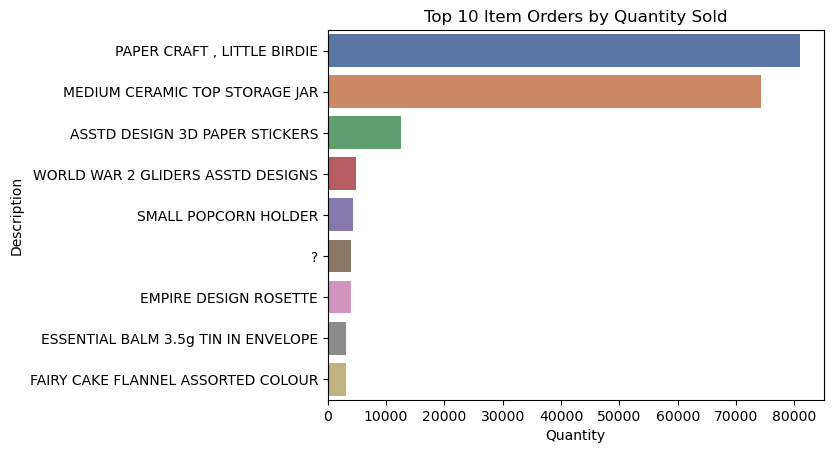

In [6]:
filtered = df.filter(df.Quantity > 2000).orderBy(df.Quantity, ascending=False)
sel = filtered.select('Description','Quantity')
dfp = sel.toPandas()
dfp10 = dfp.head(10)
sns.barplot(x = dfp10.Quantity, y = dfp10.Description, palette='deep')
plt.title('Top 10 Item Orders by Quantity Sold')
plt.show();


### Looks like there's a pretty dramatic difference in the items that were sold the most. We'll uncover more about this specific pattern later - for now, we want to know whether the most sold items actually drive revenue. Are the top selling items by quantity also earning us the most money? Let's see. 

### This dataset does not provide a revenue feature, so we will create it based on Unit Price and Quantity Sold.

In [7]:
from pyspark.sql.functions import round

dfnew = df.withColumn('revenue', df.Quantity*df.UnitPrice)
dfnew = dfnew.withColumn('revenue', round(dfnew.revenue, 2))
dfnew.show(10)

+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------+
|_c0|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|revenue|
+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------+
|  0|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|   15.3|
|  1|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|  20.34|
|  2|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|   22.0|
|  3|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|  20.34|
|  4|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|  20.34|
|  5|   536365|    22752|SET 7 BABUSHKA 

In [8]:
dfrev = dfnew.groupBy('Description').agg({'revenue':'sum'})
dfrev = dfrev.withColumnRenamed('sum(revenue)', 'total_revenue')
dfrev = dfrev.withColumn('total_revenue', round(dfrev['total_revenue'], 2)).orderBy(dfrev.total_revenue, ascending=False)

dfrev.show(10)

+--------------------+-------------+
|         Description|total_revenue|
+--------------------+-------------+
|      DOTCOM POSTAGE|    206245.48|
|REGENCY CAKESTAND...|    164762.19|
|WHITE HANGING HEA...|     99668.47|
|       PARTY BUNTING|     98302.98|
|JUMBO BAG RED RET...|     92356.03|
|  RABBIT NIGHT LIGHT|     66756.59|
|             POSTAGE|     66230.64|
|PAPER CHAIN KIT 5...|     63791.94|
|ASSORTED COLOUR B...|     58959.73|
|       CHILLI LIGHTS|     53768.06|
+--------------------+-------------+
only showing top 10 rows



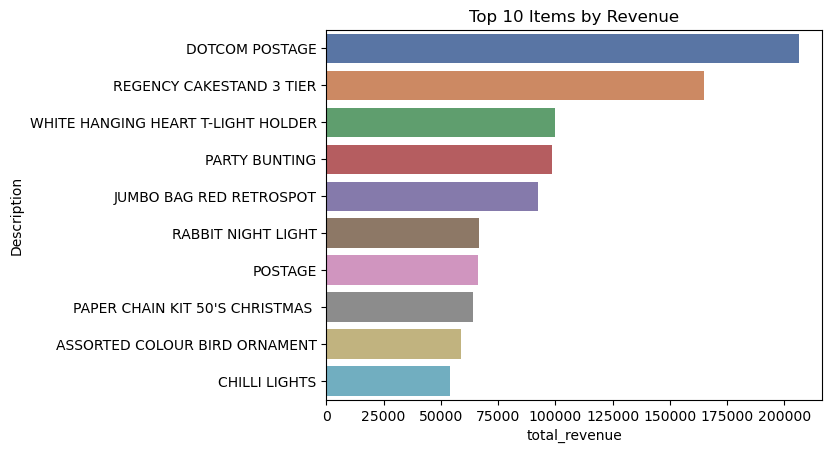

In [9]:
dfp = dfrev.toPandas()
dfp10 = dfp.head(10)
sns.barplot(x = dfp10.total_revenue, y = dfp10.Description, palette='deep')
plt.title('Top 10 Items by Revenue')
plt.show();

### The little birdie paper crafts and medium top storage jars are nowhere to be seen! It looks like postage racks in some change as does a few other random items. This is good intel for the company - we can roll with the popularity and create a few marketing materials for items like the Regency Cakestand to see if we can capture the customer drive to promote more sales. 

### As queries are about to get more intense, further work will be completed in a SparkSQL temporary view. 

In [10]:
df.createOrReplaceTempView('retail')

In [11]:
res = spark.sql('SELECT * FROM retail LIMIT 10;')

res.show()

+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|_c0|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|  0|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|  1|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|  2|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|  3|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|  4|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|  5|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United K

### It's great to know what items are selling the most, but this is an international company - that complicates things as we have to work across major shipping differentials, language barriers, and other international business obstacles. Which countries purchase the most products?

In [12]:
res = spark.sql('SELECT Country, SUM(Quantity) AS total_sold FROM retail GROUP BY Country ORDER BY total_sold DESC LIMIT 20;')
res.show()

+---------------+----------+
|        Country|total_sold|
+---------------+----------+
| United Kingdom|   4263829|
|    Netherlands|    200128|
|           EIRE|    142637|
|        Germany|    117448|
|         France|    110480|
|      Australia|     83653|
|         Sweden|     35637|
|    Switzerland|     30325|
|          Spain|     26824|
|          Japan|     25218|
|        Belgium|     23152|
|         Norway|     19247|
|       Portugal|     16180|
|        Finland|     10666|
|Channel Islands|      9479|
|        Denmark|      8188|
|          Italy|      7999|
|         Cyprus|      6317|
|      Singapore|      5234|
|        Austria|      4827|
+---------------+----------+



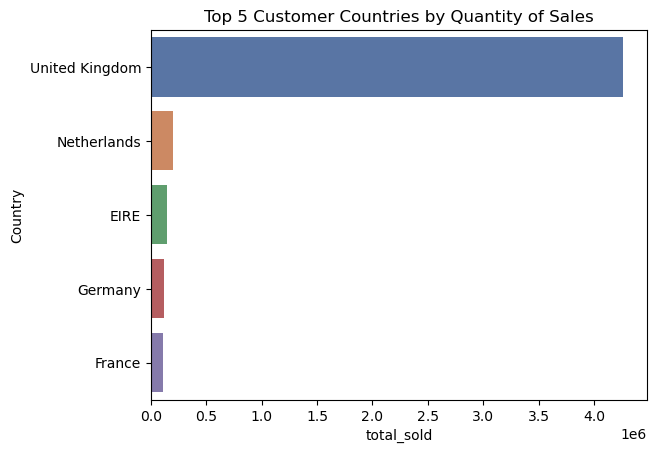

In [13]:
dfp = res.toPandas().head(5)
sns.barplot(x=dfp.total_sold, y=dfp.Country, palette='deep')
plt.title('Top 5 Customer Countries by Quantity of Sales')
plt.show();

### As a UK based company, looks like the UK wins by far in terms of sheer quantity of sales. Similar to the most popular products, is UK also our highest revenue driver?

In [14]:
def sql(statement):
    res = spark.sql(statement)
    res.show()
    return res

In [15]:
res = sql("""WITH cte AS 
            (SELECT *, Quantity*UnitPrice AS revenue 
            FROM retail)
        SELECT Country, ROUND(SUM(revenue),2) AS total_revenue
        FROM cte
        GROUP BY Country
        ORDER BY total_revenue DESC
        LIMIT 20;""")

+---------------+-------------+
|        Country|total_revenue|
+---------------+-------------+
| United Kingdom|   8187806.36|
|    Netherlands|    284661.54|
|           EIRE|    263276.82|
|        Germany|    221698.21|
|         France|     197403.9|
|      Australia|    137077.27|
|    Switzerland|     56385.35|
|          Spain|     54774.58|
|        Belgium|     40910.96|
|         Sweden|     36595.91|
|          Japan|     35340.62|
|         Norway|     35163.46|
|       Portugal|     29367.02|
|        Finland|     22326.74|
|Channel Islands|     20086.29|
|        Denmark|     18768.14|
|          Italy|     16890.51|
|         Cyprus|     12946.29|
|        Austria|     10154.32|
|      Hong Kong|     10117.04|
+---------------+-------------+



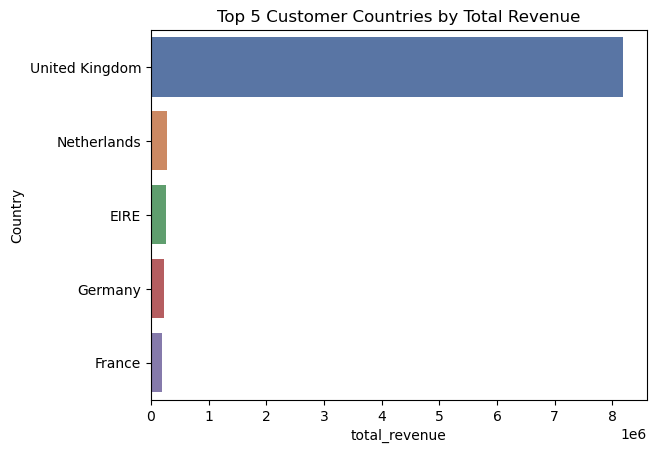

In [16]:
dfp = res.toPandas().head(5)
sns.barplot(x=dfp.total_revenue, y=dfp.Country)
plt.title('Top 5 Customer Countries by Total Revenue')
plt.show();

### It appears the UK is also our highest revenue driver by a long shot! In that case, let's take a deeper look at patterns within the UK to understand our customer base more. 

### What are the top products in the UK according to revenue?

In [17]:
res = sql("""

WITH cte AS 
(SELECT *, ROUND(Quantity*UnitPrice, 2) AS revenue 
FROM retail)

SELECT Description, ROUND(SUM(revenue),2) AS total_revenue
FROM cte
WHERE Country = 'United Kingdom'
GROUP BY Description
ORDER BY total_revenue DESC
LIMIT 10;

""")

+--------------------+-------------+
|         Description|total_revenue|
+--------------------+-------------+
|      DOTCOM POSTAGE|    206245.48|
|REGENCY CAKESTAND...|    134405.94|
|WHITE HANGING HEA...|     93953.07|
|       PARTY BUNTING|     92501.73|
|JUMBO BAG RED RET...|     84516.44|
|PAPER CHAIN KIT 5...|     61888.19|
|ASSORTED COLOUR B...|     54662.15|
|       CHILLI LIGHTS|     52986.86|
|PICNIC BASKET WIC...|      39619.5|
|BLACK RECORD COVE...|      39387.0|
+--------------------+-------------+



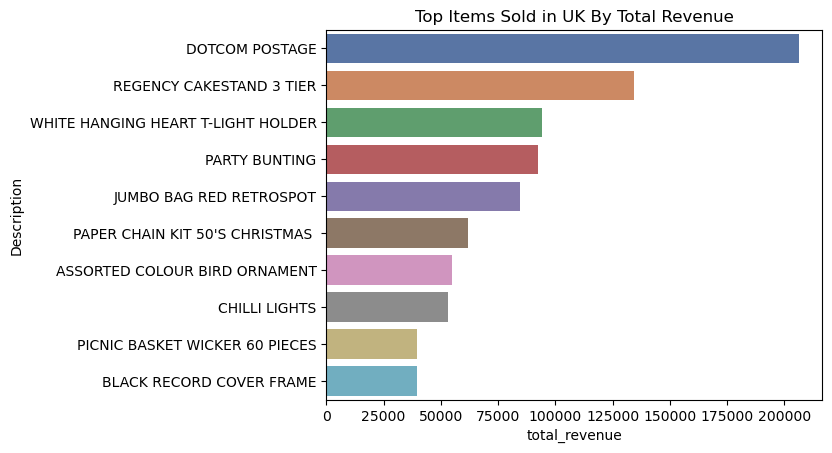

In [18]:
dfp = res.toPandas()
sns.barplot(x=dfp.total_revenue, y=dfp.Description, palette='deep')
plt.title('Top Items Sold in UK By Total Revenue')
plt.show();

### There's that postage and cakestand again - since UK generates the most revenue by such a wide margin, it makes sense that the top items sold overall are mostly in line with the top items sold in the UK. This helps! It shows that certain items are particularly popular in the UK, and that helps direct our marketing to one language and our operations strategy to mostly domestic for items like the cakestand and T-light holder. 

### What's the story behind these products? How do the purchasing trends change in the UK over time? 

### To address this question, I need not only a revenue feature but a cumulative revenue feature - that is, how does revenue change over the year's worth of transaction data for each product?

In [19]:
res = sql("""

SELECT InvoiceDate
FROM retail
ORDER BY InvoiceDate
LIMIT 1;

""")

+-------------------+
|        InvoiceDate|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



In [20]:
res = sql("""

SELECT InvoiceDate
FROM retail
ORDER BY InvoiceDate DESC
LIMIT 1;

""")

+-------------------+
|        InvoiceDate|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



In [26]:
res = sql("""

WITH cte AS (
SELECT *, ROUND(Quantity*UnitPrice, 2) AS revenue 
FROM retail
),

    cte2 AS (
    SELECT Description, revenue, InvoiceDate,
        ROUND(SUM(revenue) OVER(PARTITION BY Description ORDER BY InvoiceDate 
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW),2) AS cumulative_rev
    FROM cte
    WHERE Country = 'United Kingdom'
    ),
    
    cte3 AS (
    SELECT 
                    Description AS item,                
                    EXTRACT(MONTH FROM InvoiceDate) AS month,
                    EXTRACT(YEAR FROM InvoiceDate) AS year,
                    cumulative_rev
    FROM cte2
    WHERE Description IN
        (SELECT Description
        FROM cte2
        GROUP BY Description
        HAVING MAX(cumulative_rev) > 80000)
)

SELECT item, month, year, AVG(cumulative_rev) AS monthly_cumulative_rev
FROM cte3
GROUP BY item, month, year
ORDER BY year, month

""")

+--------------------+-----+----+----------------------+
|                item|month|year|monthly_cumulative_rev|
+--------------------+-----+----+----------------------+
|      DOTCOM POSTAGE|   12|2010|    14941.052222222219|
|       PARTY BUNTING|   12|2010|     635.1977272727273|
|JUMBO BAG RED RET...|   12|2010|    2218.4712711864418|
|REGENCY CAKESTAND...|   12|2010|    13797.811213872832|
|WHITE HANGING HEA...|   12|2010|     5455.776808510637|
|       PARTY BUNTING|    1|2011|     2211.349122807017|
|      DOTCOM POSTAGE|    1|2011|    32406.397258064517|
|JUMBO BAG RED RET...|    1|2011|     6407.506306306306|
|REGENCY CAKESTAND...|    1|2011|    29886.535846153864|
|WHITE HANGING HEA...|    1|2011|    19010.510722222225|
|       PARTY BUNTING|    2|2011|     5137.755999999997|
|      DOTCOM POSTAGE|    2|2011|     43860.32389830508|
|JUMBO BAG RED RET...|    2|2011|      10675.5124137931|
|REGENCY CAKESTAND...|    2|2011|    36976.011076923125|
|WHITE HANGING HEA...|    2|201

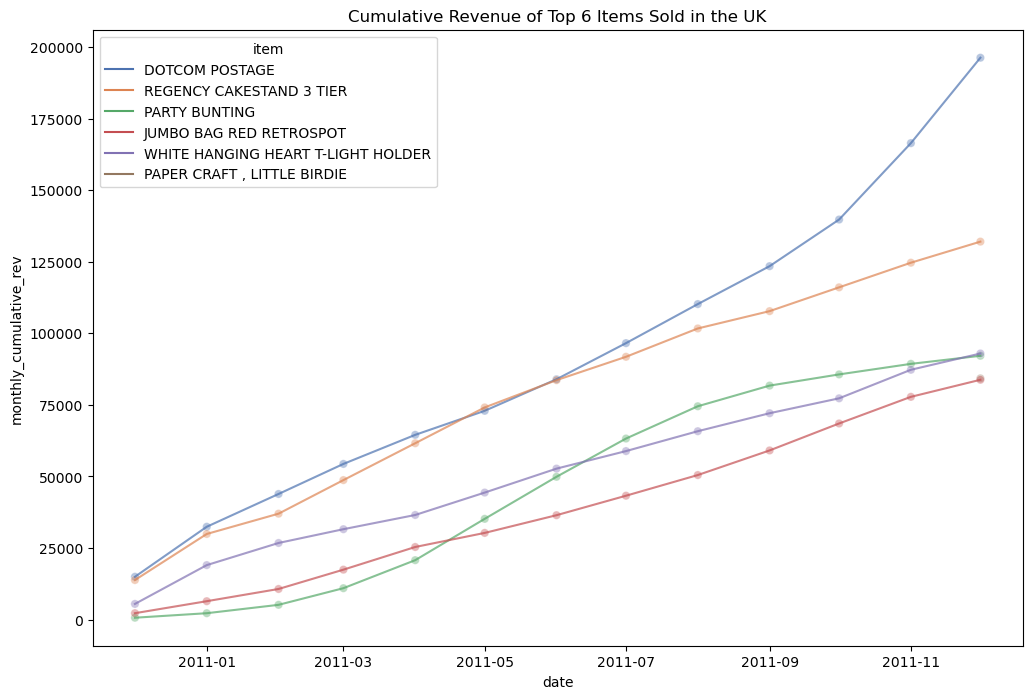

In [27]:
dfp = res.toPandas()

dfp['date'] = pd.to_datetime(dfp['year'].astype(str) + '-' + dfp['month'].astype(str) + '-01')

plt.figure(figsize=(12,8))
sns.lineplot(x=dfp.date, y=dfp.monthly_cumulative_rev, hue=dfp.item, alpha=0.7)
sns.scatterplot(x='date', y='monthly_cumulative_rev', hue='item', data=dfp, marker='o', alpha=0.4, legend=False)

plt.title('Cumulative Revenue of Top 6 Items Sold in the UK')
plt.show();

### It appears revenue due to postage costs has been on the rise over the last few months, which is generally to our benefit. However, this is likely due to volume of order increase or other features beyond our direct control. 

### The other products look healthy with the exception of party bunting - I detect a faint plateau over the last few months that may indicate that party bunting demand is beginning to fall. We should keep an eye on that to avoid overproduction. 

### What about the other most profitable countries? How do postage revenue and party bunting revenue look there? Is postage on the rise and party bunting falling in demand? As a reminder, the other countries were Netherlands, EIRE (Ireland), France, and Germany.

**************************************************
Generating SQL Query for Netherlands...
**************************************************
+-------------+-----+----+----------------------+
|         item|month|year|monthly_cumulative_rev|
+-------------+-----+----+----------------------+
|      POSTAGE|   12|2010|                  22.5|
|      POSTAGE|    1|2011|                  45.0|
|      POSTAGE|    2|2011|                 160.0|
|      POSTAGE|    3|2011|                 288.0|
|      POSTAGE|    4|2011|                 480.0|
|      POSTAGE|    5|2011|                 650.0|
|      POSTAGE|    6|2011|                779.25|
|      POSTAGE|    7|2011|                 843.0|
|PARTY BUNTING|    8|2011|                 207.5|
|      POSTAGE|    9|2011|                 903.0|
|      POSTAGE|   10|2011|                1123.0|
|      POSTAGE|   11|2011|              1402.125|
+-------------+-----+----+----------------------+



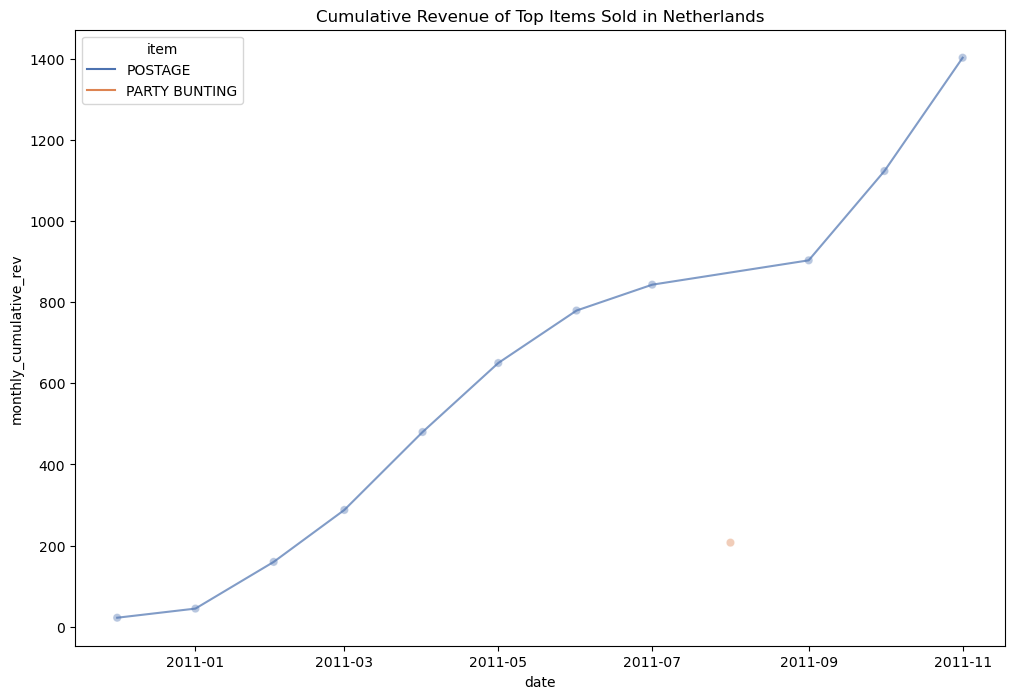

**************************************************
Generating SQL Query for EIRE...
**************************************************
+-------------+-----+----+----------------------+
|         item|month|year|monthly_cumulative_rev|
+-------------+-----+----+----------------------+
|PARTY BUNTING|    2|2011|                 44.55|
|PARTY BUNTING|    4|2011|                 64.35|
|PARTY BUNTING|    5|2011|                 306.5|
|PARTY BUNTING|    6|2011|     535.4499999999999|
|PARTY BUNTING|    7|2011|                 842.5|
|PARTY BUNTING|    9|2011|    1197.3999999999999|
|PARTY BUNTING|   10|2011|    1304.6499999999999|
|PARTY BUNTING|   11|2011|               1732.75|
+-------------+-----+----+----------------------+



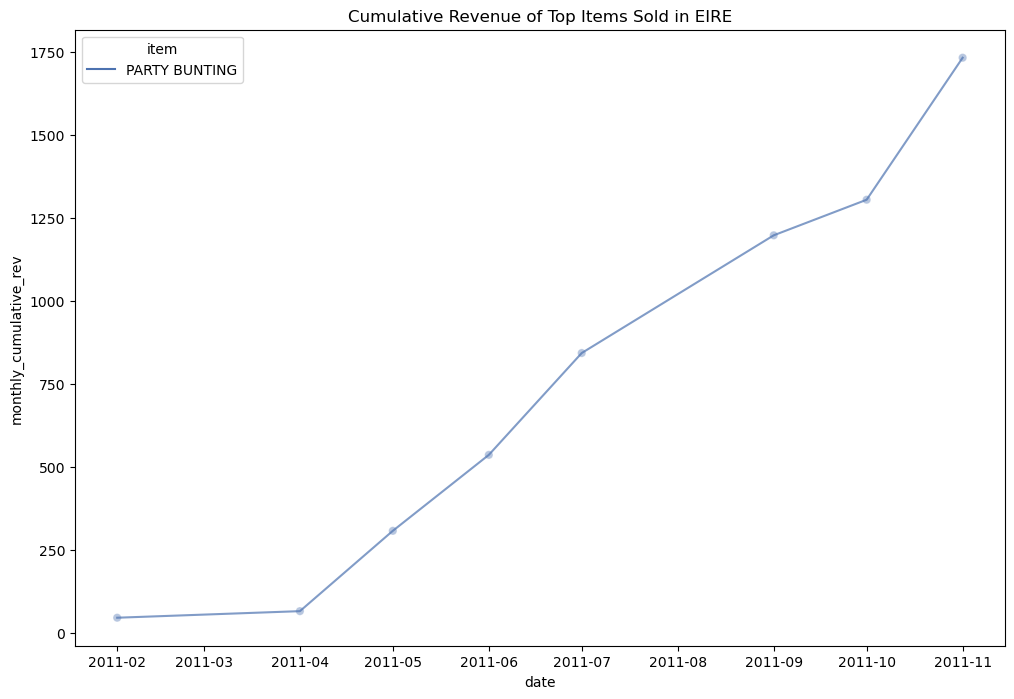

**************************************************
Generating SQL Query for France...
**************************************************
+-------------+-----+----+----------------------+
|         item|month|year|monthly_cumulative_rev|
+-------------+-----+----+----------------------+
|PARTY BUNTING|   12|2010|                 23.25|
|      POSTAGE|   12|2010|     515.6470588235294|
|PARTY BUNTING|    1|2011|                  46.5|
|      POSTAGE|    1|2011|               1672.56|
|PARTY BUNTING|    2|2011|                  96.0|
|      POSTAGE|    2|2011|                2885.4|
|PARTY BUNTING|    3|2011|                 155.4|
|      POSTAGE|    3|2011|                3663.0|
|PARTY BUNTING|    4|2011|                 165.3|
|      POSTAGE|    4|2011|                4435.2|
|PARTY BUNTING|    5|2011|                 234.6|
|      POSTAGE|    5|2011|             5200.0625|
|PARTY BUNTING|    6|2011|                 284.1|
|      POSTAGE|    6|2011|               6790.44|
|PARTY BUNTIN

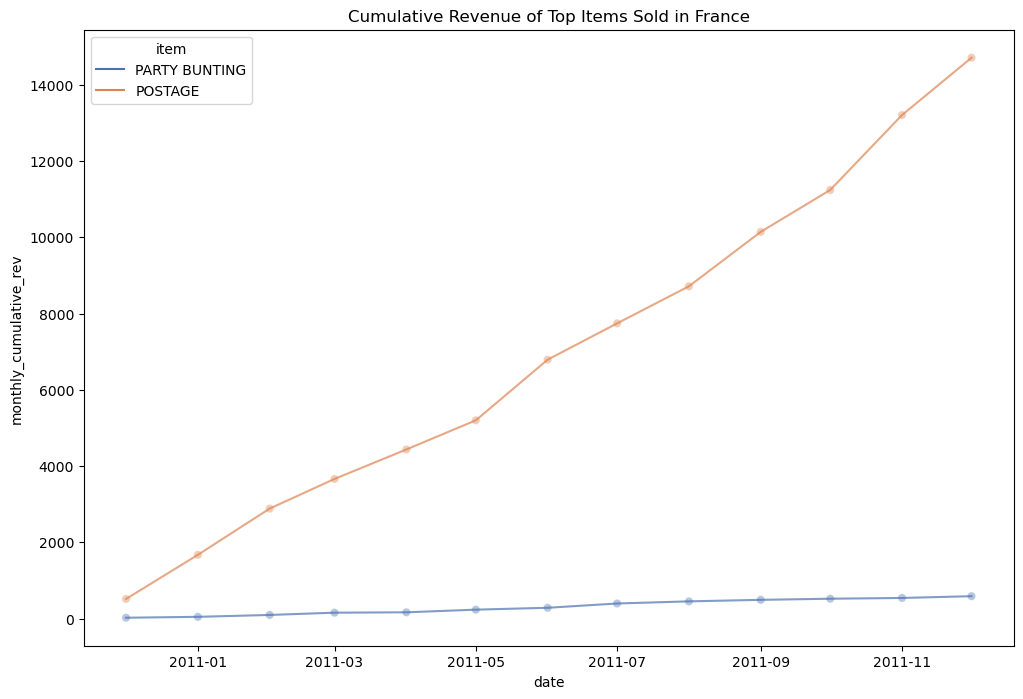

**************************************************
Generating SQL Query for Germany...
**************************************************
+-------------+-----+----+----------------------+
|         item|month|year|monthly_cumulative_rev|
+-------------+-----+----+----------------------+
|      POSTAGE|   12|2010|     855.3333333333334|
|PARTY BUNTING|    1|2011|                  46.5|
|      POSTAGE|    1|2011|    2760.8275862068967|
|      POSTAGE|    2|2011|    3845.6470588235293|
|PARTY BUNTING|    3|2011|     76.19999999999999|
|      POSTAGE|    3|2011|     4937.333333333333|
|      POSTAGE|    4|2011|                6372.0|
|      POSTAGE|    5|2011|             8130.4375|
|      POSTAGE|    6|2011|      9615.57142857143|
|      POSTAGE|    7|2011|    10812.739130434782|
|      POSTAGE|    8|2011|    12357.727272727272|
|PARTY BUNTING|    9|2011|                 145.5|
|      POSTAGE|    9|2011|    13802.885714285714|
|      POSTAGE|   10|2011|    16053.204081632653|
|      POSTA

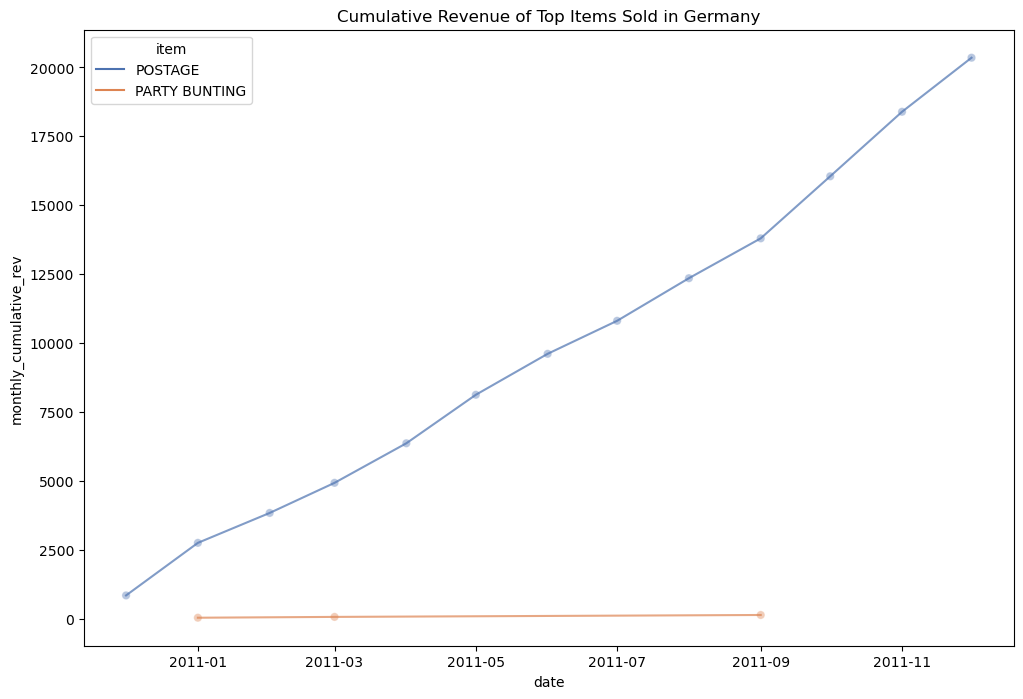

In [28]:
for country in ['Netherlands','EIRE','France','Germany']:
    
    print('*'*50)
    print(f'Generating SQL Query for {country}...')
    print('*'*50)
    
    res = sql(f"""

    WITH cte AS (
    SELECT *, ROUND(Quantity*UnitPrice, 2) AS revenue 
    FROM retail
    ),

        cte2 AS (
        SELECT Description, revenue, InvoiceDate,
            ROUND(SUM(revenue) OVER(PARTITION BY Description ORDER BY InvoiceDate 
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW),2) AS cumulative_rev
        FROM cte
        WHERE Country = '{country}'
        ),

        cte3 AS (
        SELECT 
                        Description AS item,                
                        EXTRACT(MONTH FROM InvoiceDate) AS month,
                        EXTRACT(YEAR FROM InvoiceDate) AS year,
                        cumulative_rev
        FROM cte2
        WHERE Description LIKE '%POSTAGE' 
            OR Description = 'PARTY BUNTING'
    )

    SELECT item, month, year, AVG(cumulative_rev) AS monthly_cumulative_rev
    FROM cte3
    GROUP BY item, month, year
    ORDER BY year, month

    """)
    
    dfp = res.toPandas()

    dfp['date'] = pd.to_datetime(dfp['year'].astype(str) + '-' + dfp['month'].astype(str) + '-01')

    plt.figure(figsize=(12,8))
    sns.lineplot(x=dfp.date, y=dfp.monthly_cumulative_rev, hue=dfp.item, alpha=0.7)
    sns.scatterplot(x='date', y='monthly_cumulative_rev', hue='item', data=dfp, marker='o', alpha=0.4, legend=False)

    plt.title(f'Cumulative Revenue of Top Items Sold in {country}')
    plt.show();

### I can see that postage revenue follows a late 2011 spike similar to the UK, and party bunting is not on the rise in any other top country except Ireland.

### What are the top selling items for other countries? Do other nations love the regency cake stand and T-light holder like the UK does? This will allow us to develop more targeted shipping/exporting strategies.

**************************************************
Generating SQL Query for Netherlands...
**************************************************
+--------------------+-----+----+----------------------+
|                item|month|year|monthly_cumulative_rev|
+--------------------+-----+----+----------------------+
|ROUND SNACK BOXES...|   12|2010|                 489.6|
| SPACEBOY LUNCH BOX |   12|2010|                 211.2|
|DOLLY GIRL LUNCH BOX|    1|2011|    422.40000000000003|
|ROUND SNACK BOXES...|    1|2011|                 489.6|
|ROUND SNACK BOXES...|    1|2011|    1101.6000000000001|
| SPACEBOY LUNCH BOX |    1|2011|                 880.0|
|DOLLY GIRL LUNCH BOX|    2|2011|                1161.6|
|ROUND SNACK BOXES...|    2|2011|                 734.4|
|ROUND SNACK BOXES...|    2|2011|                1713.6|
| SPACEBOY LUNCH BOX |    2|2011|    1478.4000000000003|
|DOLLY GIRL LUNCH BOX|    3|2011|    2029.8000000000002|
|ROUND SNACK BOXES...|    3|2011|    1162.8000000000002|
| S

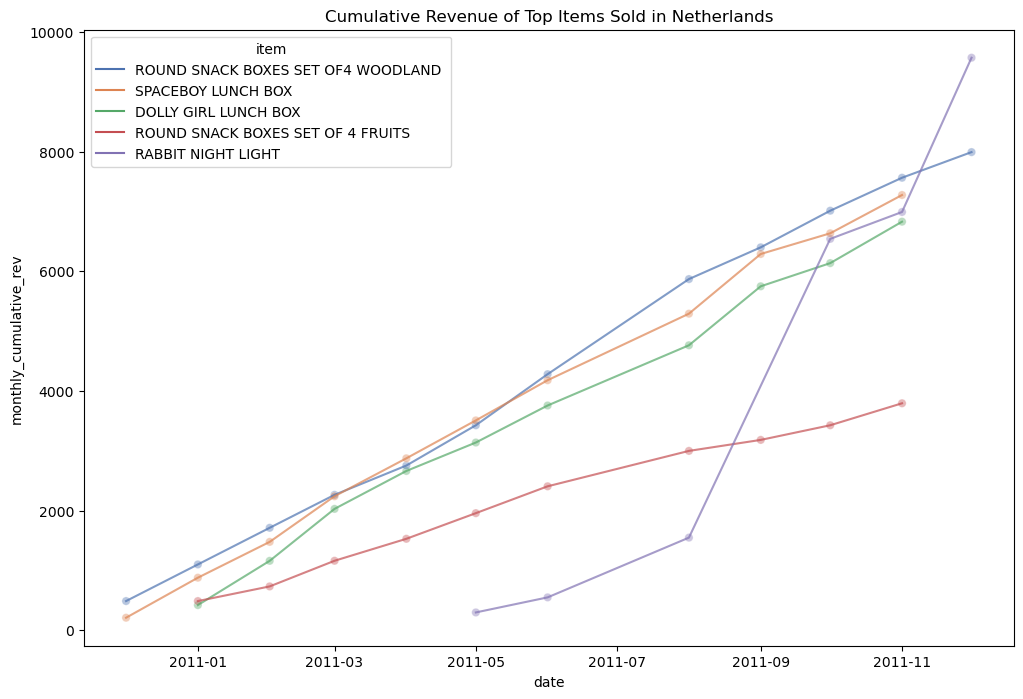

**************************************************
Generating SQL Query for EIRE...
**************************************************
+--------------------+-----+----+----------------------+
|                item|month|year|monthly_cumulative_rev|
+--------------------+-----+----+----------------------+
|JAM MAKING SET WI...|   12|2010|                 83.25|
|            CARRIAGE|   12|2010|                 200.0|
|REGENCY CAKESTAND...|   12|2010|    380.14285714285717|
|            CARRIAGE|    1|2011|                 400.0|
|3 TIER CAKE TIN R...|    1|2011|                1224.0|
|JAM MAKING SET WI...|    1|2011|                 481.5|
|REGENCY CAKESTAND...|    1|2011|                2284.2|
|3 TIER CAKE TIN R...|    2|2011|                 816.0|
|            CARRIAGE|    2|2011|                598.75|
|JAM MAKING SET WI...|    2|2011|                 642.0|
|REGENCY CAKESTAND...|    2|2011|    2534.7999999999997|
|3 TIER CAKE TIN R...|    3|2011|                1428.0|
|         

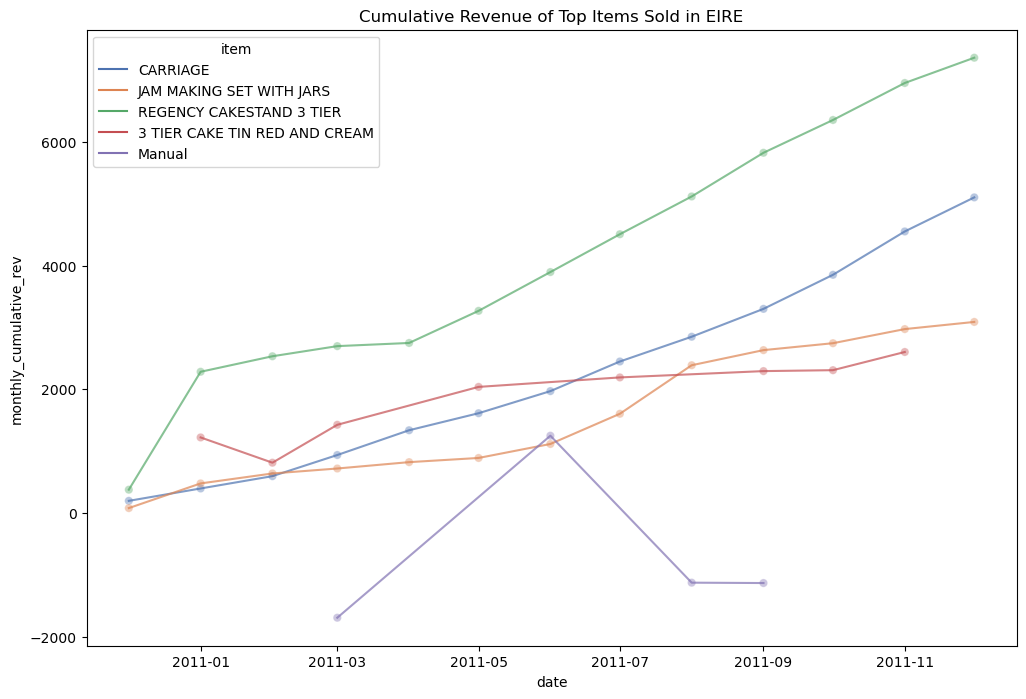

**************************************************
Generating SQL Query for France...
**************************************************
+--------------------+-----+----+----------------------+
|                item|month|year|monthly_cumulative_rev|
+--------------------+-----+----+----------------------+
|             POSTAGE|   12|2010|     515.6470588235294|
|RED TOADSTOOL LED...|   12|2010|    203.65714285714284|
|REGENCY CAKESTAND...|   12|2010|                  25.5|
|             POSTAGE|    1|2011|               1672.56|
|RED TOADSTOOL LED...|    1|2011|    413.32499999999993|
|REGENCY CAKESTAND...|    1|2011|    142.92000000000002|
|             POSTAGE|    2|2011|                2885.4|
|RED TOADSTOOL LED...|    2|2011|     574.1999999999999|
|REGENCY CAKESTAND...|    2|2011|    252.52499999999998|
|             POSTAGE|    3|2011|                3663.0|
|REGENCY CAKESTAND...|    3|2011|                 359.8|
|RED TOADSTOOL LED...|    3|2011|     707.1428571428571|
|REGENCY

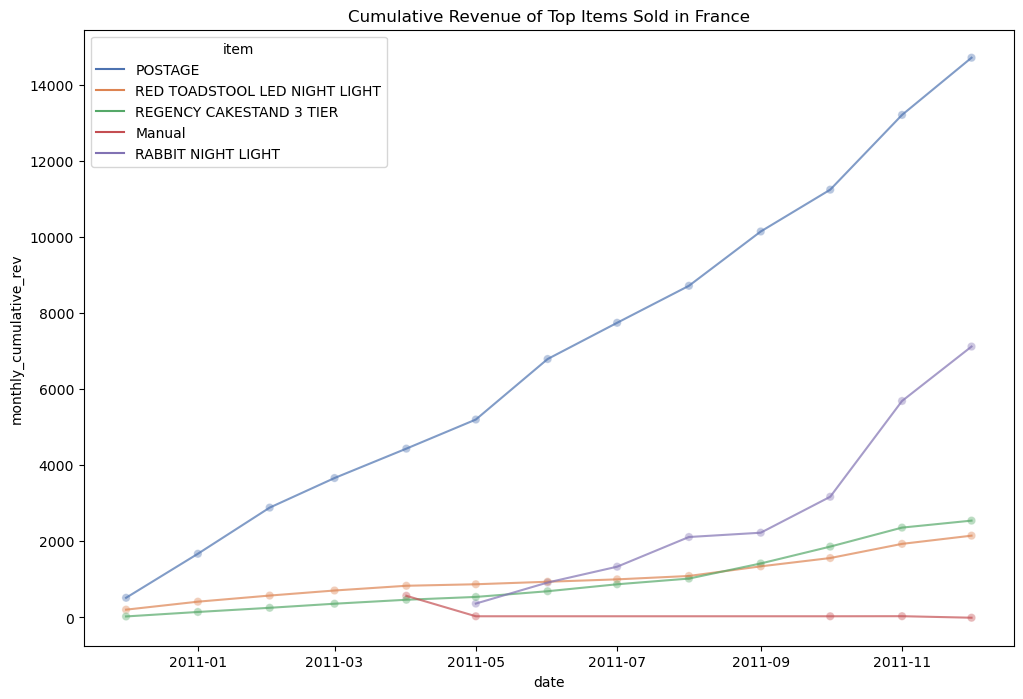

**************************************************
Generating SQL Query for Germany...
**************************************************
+--------------------+-----+----+----------------------+
|                item|month|year|monthly_cumulative_rev|
+--------------------+-----+----+----------------------+
|             POSTAGE|   12|2010|     855.3333333333334|
|REGENCY CAKESTAND...|   12|2010|     661.5428571428572|
|ROUND SNACK BOXES...|   12|2010|    212.39999999999998|
|             POSTAGE|    1|2011|    2760.8275862068967|
|REGENCY CAKESTAND...|    1|2011|    1459.6499999999999|
|ROUND SNACK BOXES...|    1|2011|     433.6499999999999|
|             POSTAGE|    2|2011|    3845.6470588235293|
|REGENCY CAKESTAND...|    2|2011|              2070.625|
|ROUND SNACK BOXES...|    2|2011|     546.1714285714286|
|             POSTAGE|    3|2011|     4937.333333333333|
|REGENCY CAKESTAND...|    3|2011|    2420.4409090909094|
|ROUND SNACK BOXES...|    3|2011|     732.4849999999999|
|      

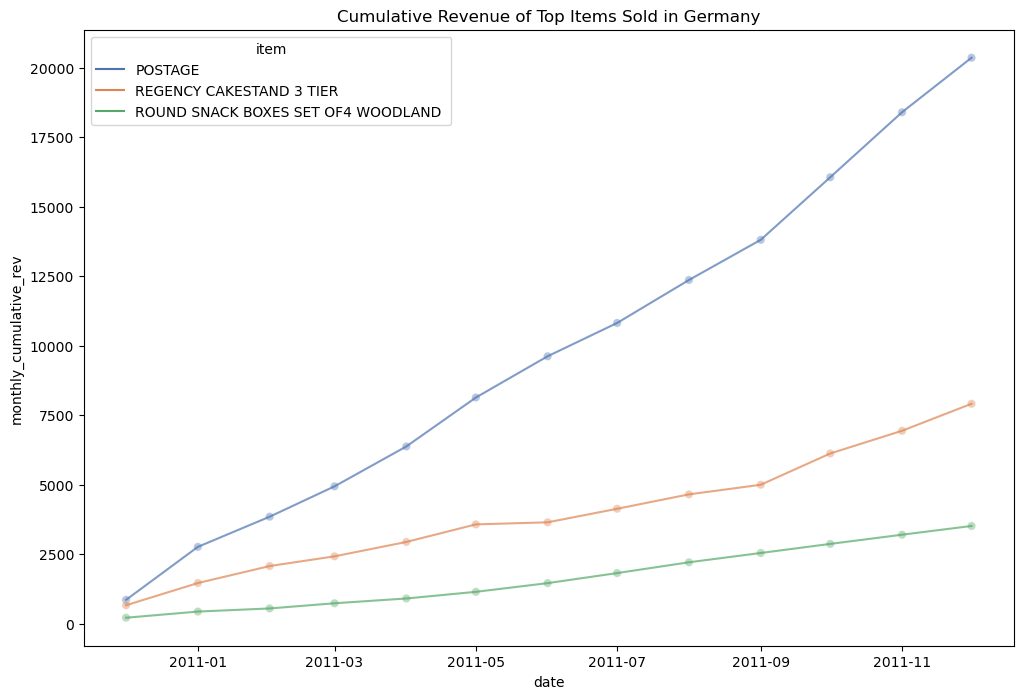

In [30]:
for country in ['Netherlands','EIRE','France','Germany']:
    
    if country == 'Netherlands':
        value = 4000
    elif country == 'EIRE':
        value = 3000
    elif country == 'France':
        value= 2000
    elif country == 'Germany':
        value = 2000
        
    print('*'*50)
    print(f'Generating SQL Query for {country}...')
    print('*'*50)
    
    res = sql(f"""

    WITH cte AS (
    SELECT *, ROUND(Quantity*UnitPrice, 2) AS revenue 
    FROM retail
    ),

        cte2 AS (
        SELECT Description, revenue, InvoiceDate,
            ROUND(SUM(revenue) OVER(PARTITION BY Description ORDER BY InvoiceDate 
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW),2) AS cumulative_rev
        FROM cte
        WHERE Country = '{country}'
        ),

        cte3 AS (
        SELECT 
                        Description AS item,                
                        EXTRACT(MONTH FROM InvoiceDate) AS month,
                        EXTRACT(YEAR FROM InvoiceDate) AS year,
                        cumulative_rev
        FROM cte2
        WHERE Description IN
            (SELECT Description
            FROM cte2
            GROUP BY Description
            HAVING MAX(cumulative_rev) > {value})
    )

    SELECT item, month, year, AVG(cumulative_rev) AS monthly_cumulative_rev
    FROM cte3
    GROUP BY item, month, year
    ORDER BY year, month

    """)
    
    dfp = res.toPandas()

    dfp['date'] = pd.to_datetime(dfp['year'].astype(str) + '-' + dfp['month'].astype(str) + '-01')

    plt.figure(figsize=(12,8))
    sns.lineplot(x=dfp.date, y=dfp.monthly_cumulative_rev, hue=dfp.item, alpha=0.9)
    sns.scatterplot(x='date', y='monthly_cumulative_rev', hue='item', data=dfp, marker='o', alpha=0.4, legend=False)

    plt.title(f'Cumulative Revenue of Top Items Sold in {country}')
    plt.show();

### The Netherlands loves round snack boxes and lunch boxes, and Ireland and Germany share the UK's love for the regency cakestand. Perhaps the most interesting pattern is in France and Netherlands: the rabbit night light is taking off like wildfire in a few large orders. Are we planning to meet the rising production and shipping demands to those countries?

### Understanding trends in countries is helpful, but we can target our strategies even further by looking into our top individual customers. Who's our most profitable buyer, and what are they buying?

In [31]:
res = sql("""


SELECT *, ROUND(Quantity*UnitPrice, 2) AS revenue 
FROM retail
ORDER BY revenue DESC
LIMIT 10;

""")

+------+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+--------+
|   _c0|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country| revenue|
+------+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+--------+
|540421|   581483|    23843|PAPER CRAFT , LIT...|   80995|2011-12-09 09:15:00|     2.08|   16446.0|United Kingdom|168469.6|
| 61619|   541431|    23166|MEDIUM CERAMIC TO...|   74215|2011-01-18 10:01:00|     1.04|   12346.0|United Kingdom| 77183.6|
|222680|   556444|    22502|PICNIC BASKET WIC...|      60|2011-06-10 15:28:00|    649.5|   15098.0|United Kingdom| 38970.0|
| 15017|   537632|AMAZONFEE|          AMAZON FEE|       1|2010-12-07 15:08:00| 13541.33|      NULL|United Kingdom|13541.33|
|299982|  A563185|        B|     Adjust bad debt|       1|2011-08-12 14:50:00| 11062.06|      NULL|United Kingdom|11062.06|
|173382|

In [32]:
res = sql("""

WITH cte AS (
SELECT *, ROUND(Quantity*UnitPrice, 2) AS revenue 
FROM retail
)

SELECT CustomerID, Country, ROUND(SUM(revenue),2) AS total_rev
FROM cte
WHERE CustomerID IS NOT NULL
GROUP BY CustomerID, Country
ORDER BY total_rev DESC
LIMIT 10;


""")

+----------+--------------+---------+
|CustomerID|       Country|total_rev|
+----------+--------------+---------+
|   14646.0|   Netherlands|279489.02|
|   18102.0|United Kingdom|256438.49|
|   17450.0|United Kingdom|187482.17|
|   14911.0|          EIRE|132572.62|
|   12415.0|     Australia|123725.45|
|   14156.0|          EIRE|113384.14|
|   17511.0|United Kingdom| 88125.38|
|   16684.0|United Kingdom| 65892.08|
|   13694.0|United Kingdom|  62653.1|
|   15311.0|United Kingdom| 59419.34|
+----------+--------------+---------+



### It appears our top customer is in the Netherlands. What do they purchase the most?

In [33]:
res = sql("""

WITH customer_revenue AS (
    SELECT 
        CustomerID,
        Country,
        ROUND(SUM(Quantity * UnitPrice), 2) AS total_rev
    FROM retail
    WHERE CustomerID IS NOT NULL
    GROUP BY CustomerID, Country
    ORDER BY total_rev DESC
    LIMIT 1
),
    
    purchased as (
    SELECT 
        CustomerID, Description, UnitPrice,
        SUM(Quantity) as total_purchased 
    FROM retail
    WHERE 
        InvoiceNo NOT LIKE 'C%' AND
        CustomerID IN (SELECT CustomerID FROM customer_revenue)
    GROUP BY Description, CustomerID, UnitPrice
    ORDER BY CustomerID
)

SELECT *, ROUND(UnitPrice*total_purchased,2) AS total_revenue
FROM purchased
ORDER BY total_revenue DESC
LIMIT 5
;



""")

+----------+--------------------+---------+---------------+-------------+
|CustomerID|         Description|UnitPrice|total_purchased|total_revenue|
+----------+--------------------+---------+---------------+-------------+
|   14646.0|ROUND SNACK BOXES...|     2.55|           3120|       7956.0|
|   14646.0| SPACEBOY LUNCH BOX |     1.65|           4480|       7392.0|
|   14646.0|  RABBIT NIGHT LIGHT|     2.08|           3361|      6990.88|
|   14646.0|DOLLY GIRL LUNCH BOX|     1.65|           4096|       6758.4|
|   14646.0|ROUND SNACK BOXES...|     2.55|           1584|       4039.2|
+----------+--------------------+---------+---------------+-------------+



<Figure size 600x1000 with 0 Axes>

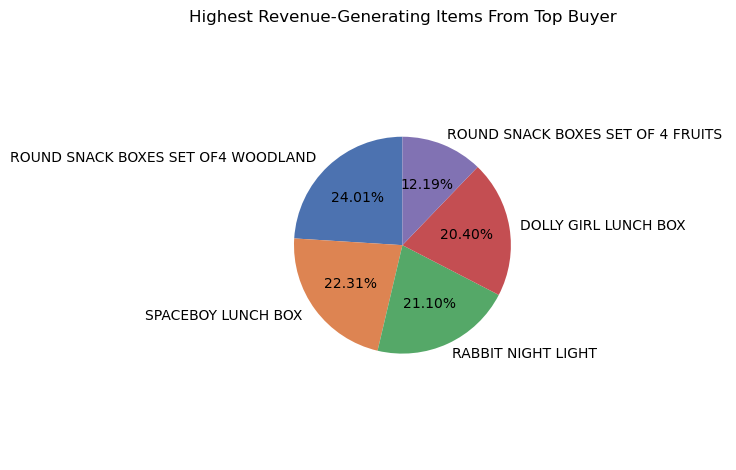

In [34]:
dfp = res.toPandas()

plt.figure(figsize=(6, 10))
dfp.plot.pie(y='total_revenue', labels=dfp.Description, autopct='%1.2f%%', startangle=90, legend=False)
plt.axis('equal')
plt.ylabel('')
plt.title('Highest Revenue-Generating Items From Top Buyer')
plt.tight_layout()
plt.show();

### Similar to the influence of the UK's top items on proportion of the top items sold worldwide, this top Netherlands customer seems to drive the observable spending habits for the whole country! This intel is helpful for us in two ways: 

### 1) We may not need to increase production and develop complex marketing strategies for the round snack boxes and lunch boxes in Netherlands as originally supposed, as it seems we're mostly working to satisfy one customer
### 2) In light of that, we should cultivate a strong relationship with this customer through deals, contracts, and guarantees to ensure their continued business in the future. The more we can plan for, the better. 

### Now, It's nice to know what products, countries, and customers bring in the most cash. But what about cancellations and expenses? Which items cost us the most money overall?

In [53]:
res = sql("""

SELECT Description, COUNT(InvoiceNo) AS total_returned, SUM(UnitPrice*Quantity) AS total_value
FROM retail
WHERE InvoiceNo LIKE "C%"
GROUP BY Description
ORDER BY total_returned DESC
LIMIT 10

""")

+--------------------+--------------+-------------------+
|         Description|total_returned|        total_value|
+--------------------+--------------+-------------------+
|              Manual|           244|         -146784.46|
|REGENCY CAKESTAND...|           181| -9722.549999999997|
|             POSTAGE|           126|          -11871.24|
|JAM MAKING SET WI...|            87|           -1012.79|
|            Discount|            77| -5696.219999999999|
|SET OF 3 CAKE TIN...|            74|            -744.95|
|             SAMPLES|            61|           -3112.44|
|STRAWBERRY CERAMI...|            55|            -415.75|
|ROSES REGENCY TEA...|            54|           -1150.35|
|RECIPE BOX PANTRY...|            47|-421.05000000000007|
+--------------------+--------------+-------------------+



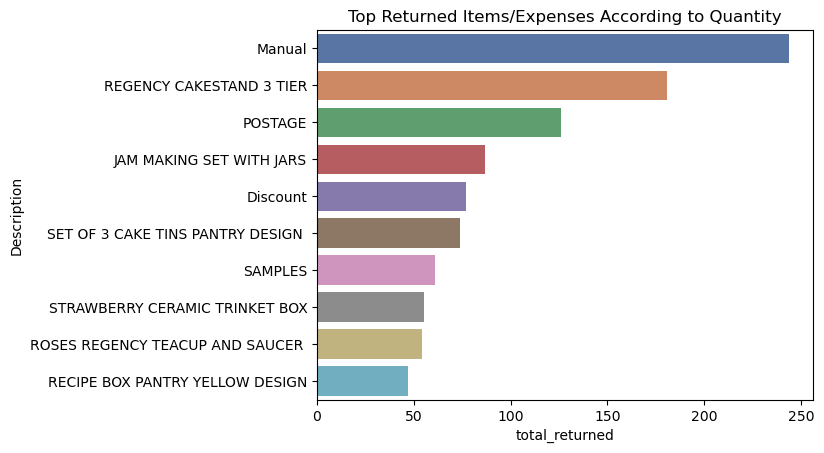

In [54]:
dfp = res.toPandas()

sns.barplot(x='total_returned',y='Description',data=dfp)
plt.title('Top Returned Items/Expenses According to Quantity')
plt.show();

### According to quantity, looks like we face expenses with manuals, postage, and discounts. The most frequently returned item is the regency cakestand, which is slightly expected due to it's rising popularity in many countries.

### But it's not just a quantity question - we want to know what's actually dragging our money out the door. Where do we lose value?

+--------------------+--------------+------------------+
|         Description|total_returned|       total_value|
+--------------------+--------------+------------------+
|          AMAZON FEE|            32|235281.59000000003|
|PAPER CRAFT , LIT...|             1|          168469.6|
|              Manual|           244|         146784.46|
|MEDIUM CERAMIC TO...|            10| 77479.64000000001|
|             POSTAGE|           126|          11871.24|
|REGENCY CAKESTAND...|           181| 9722.549999999997|
|     CRUK Commission|            16|           7933.43|
|        Bank Charges|            25| 7340.639999999999|
|WHITE HANGING HEA...|            42| 6624.299999999999|
|FAIRY CAKE FLANNE...|             3| 6591.420000000001|
+--------------------+--------------+------------------+



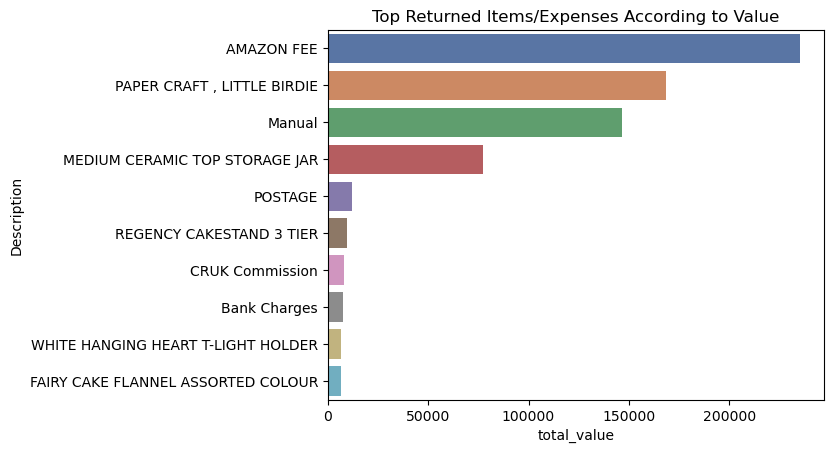

In [55]:
res = sql("""

SELECT Description, COUNT(InvoiceNo) AS total_returned, 
        -SUM(UnitPrice*Quantity) AS total_value
FROM retail
WHERE InvoiceNo LIKE "C%"
GROUP BY Description
ORDER BY total_value DESC
LIMIT 10

""")

dfp = res.toPandas()

sns.barplot(x='total_value',y='Description',data=dfp)
plt.title('Top Returned Items/Expenses According to Value')
plt.show();

### Amazon Fees are PRICY. But as far as merchandise goes, we seem to lose a good bit of cash on the Little Birdie Paper Craft and the Medium Ceramic Top Storage Jar. Where are these products going? Do we need to control our marketing a little more precisely?

In [56]:
res = sql("""

SELECT *
FROM retail
WHERE Description = "MEDIUM CERAMIC TOP STORAGE JAR"

""")

+------+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   _c0|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+------+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
| 61619|   541431|    23166|MEDIUM CERAMIC TO...|   74215|2011-01-18 10:01:00|     1.04|   12346.0|United Kingdom|
| 61624|  C541433|    23166|MEDIUM CERAMIC TO...|  -74215|2011-01-18 10:17:00|     1.04|   12346.0|United Kingdom|
|186770|   552882|    23166|MEDIUM CERAMIC TO...|      96|2011-05-12 10:10:00|     1.04|   14646.0|   Netherlands|
|187196|   552953|    23166|MEDIUM CERAMIC TO...|       4|2011-05-12 12:11:00|     1.25|   16745.0|United Kingdom|
|187718|   553005|    23166|MEDIUM CERAMIC TO...|       5|2011-05-12 16:29:00|     1.25|   14651.0|United Kingdom|
|187868|   553009|    23166|MEDIUM CERAMIC TO...|       3|2011-05-12 16:52:00|  

In [49]:
res = sql("""

SELECT *
FROM retail
WHERE Description = "PAPER CRAFT , LITTLE BIRDIE"

""")

+------+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   _c0|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+------+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|540421|   581483|    23843|PAPER CRAFT , LIT...|   80995|2011-12-09 09:15:00|     2.08|   16446.0|United Kingdom|
|540422|  C581484|    23843|PAPER CRAFT , LIT...|  -80995|2011-12-09 09:27:00|     2.08|   16446.0|United Kingdom|
+------+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+



### These are strange patterns. The return values are exaggerated in both products by single major transactions followed by immediate returns. Both customers were located in the UK. Do these customers have a history of doing this kind of thing?

In [57]:
res = sql("""

SELECT *
FROM retail
WHERE CustomerID IN ('16446.0', '12346.0')

""")

+------+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   _c0|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+------+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
| 61619|   541431|    23166|MEDIUM CERAMIC TO...|   74215|2011-01-18 10:01:00|     1.04|   12346.0|United Kingdom|
| 61624|  C541433|    23166|MEDIUM CERAMIC TO...|  -74215|2011-01-18 10:17:00|     1.04|   12346.0|United Kingdom|
|194354|   553573|    22980|PANTRY SCRUBBING ...|       1|2011-05-18 09:52:00|     1.65|   16446.0|United Kingdom|
|194355|   553573|    22982| PANTRY PASTRY BRUSH|       1|2011-05-18 09:52:00|     1.25|   16446.0|United Kingdom|
|540421|   581483|    23843|PAPER CRAFT , LIT...|   80995|2011-12-09 09:15:00|     2.08|   16446.0|United Kingdom|
|540422|  C581484|    23843|PAPER CRAFT , LIT...|  -80995|2011-12-09 09:27:00|  

### Nope. These customers do not have an extensive purchasing history with us - perhaps this could be a case for the fraud team, otherwise we can just let it go as the cancellations occurred so quickly we probably didn't lose revenue. 

### But it could be worth exploring the items returned/expenses by quantity to see what other improvements we could make.

### The most returned items are the 3 tier Regency Cakestand, the Jam Making Set w/ Jars, and the Set of 3 Cake Tins Pantry Design. What are the return patterns and how can that help us identify revisional steps?

+--------------------+---------+-------------------+----------+--------------+-------------------------+
|         Description|InvoiceNo|        InvoiceDate|CustomerID|       Country|cumulative_total_returned|
+--------------------+---------+-------------------+----------+--------------+-------------------------+
|JAM MAKING SET WI...|  C536506|2010-12-01 12:38:00|   17897.0|United Kingdom|                        6|
|JAM MAKING SET WI...|  C537417|2010-12-06 15:12:00|   13481.0|United Kingdom|                        7|
|JAM MAKING SET WI...|  C537853|2010-12-08 15:57:00|   13370.0|United Kingdom|                        9|
|JAM MAKING SET WI...|  C538693|2010-12-14 09:59:00|   16558.0|United Kingdom|                       11|
|JAM MAKING SET WI...|  C538802|2010-12-14 11:54:00|   17017.0|United Kingdom|                       15|
|JAM MAKING SET WI...|  C539289|2010-12-16 16:30:00|   18065.0|United Kingdom|                       18|
|JAM MAKING SET WI...|  C540142|2011-01-05 10:50:00|   

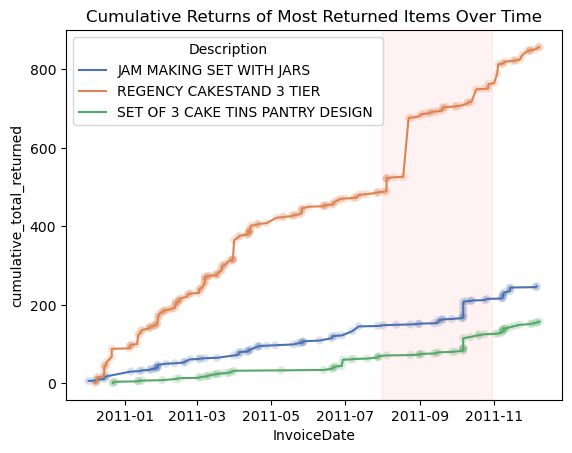

In [71]:
res = sql("""

SELECT Description, InvoiceNo, InvoiceDate, CustomerID, Country,
    -SUM(QUANTITY) OVER(PARTITION BY Description 
    ORDER BY InvoiceDate ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)
        AS cumulative_total_returned
FROM retail
WHERE DESCRIPTION IN ('REGENCY CAKESTAND 3 TIER',
    'JAM MAKING SET WITH JARS',
    'SET OF 3 CAKE TINS PANTRY DESIGN ')
    AND InvoiceNo LIKE "C%"

""")

dfp = res.toPandas()
sns.lineplot(x='InvoiceDate', y='cumulative_total_returned', data=dfp, hue='Description')
sns.scatterplot(x='InvoiceDate', y='cumulative_total_returned', data=dfp, hue='Description', alpha=0.2, legend=False)

plt.axvspan('2011-08-01', '2011-10-31', color='red', alpha=0.05)
plt.title('Cumulative Returns of Most Returned Items Over Time')
plt.show();

### It looks like we've seen the highest jumps in quantity of returns between August and October 2011 for all three items - we should look into our manufacturing details to examine our recall status and whether this is a common pattern at this time of year.

### Overall, I've taken a decent look into the e-commerce data to help this company make a few data-driven decisions in their marketing, production, and operations evaluations. Hopefully this analysis proves helpful! 

### In future analyses, I'll perform forecasting and intensive time series analysis to understand the next few years' of patterns well. 

In [72]:
spark.stop()